# Load package

In [2]:
import pandas as pd
import numpy as np
import datetime
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline 
from random import sample

# Load data from database

In [4]:
path = '../data/'
# path = 'data/NYC_2013/'
conn = sqlite3.connect(path + 'trip_data.db')

In [5]:
q_license = """
SELECT distinct(hack_license) as UNIQ_LIC
FROM trip
"""

unique_license = pd.read_sql(q_license, conn)

In [6]:
LIC_SAMPLE_NUM = 5000
sampled_drivers = sample(unique_license.UNIQ_LIC.tolist(), LIC_SAMPLE_NUM)

In [7]:
# find the pickup and dropoff time of next trip
q_sample = """
SELECT *, 
        lag(pickup_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as pickup_datetime_next,
        lag(dropoff_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as dropoff_datetime_next
    FROM trip
    WHERE hack_license in {0}
ORDER BY hack_license ASC, pickup_datetime ASC, dropoff_datetime ASC
"""

sampled_trip = pd.read_sql(q_sample.format(tuple(sampled_drivers)), conn)

In [8]:
conn.close()

In [9]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next
0,2013000005,2013000005,VTS,1,2013-06-01 15:05:00,2013-06-01 15:08:00,5,180,0.42,-73.976631,40.790504,-73.971565,40.787315,2013-06-01 15:12:00,2013-06-01 15:26:00
1,2013000005,2013000005,VTS,1,2013-06-01 15:12:00,2013-06-01 15:26:00,3,840,2.80,-73.970322,40.784058,-73.990753,40.750889,2013-06-01 15:31:00,2013-06-01 15:46:00
2,2013000005,2013000005,VTS,1,2013-06-01 15:31:00,2013-06-01 15:46:00,4,900,2.16,-73.995903,40.743778,-73.987251,40.722488,2013-06-01 15:49:00,2013-06-01 16:00:00
3,2013000005,2013000005,VTS,1,2013-06-01 15:49:00,2013-06-01 16:00:00,3,660,2.63,-73.983421,40.721920,-74.002678,40.706558,2013-06-01 16:02:00,2013-06-01 16:14:00
4,2013000005,2013000005,VTS,1,2013-06-01 16:02:00,2013-06-01 16:14:00,4,720,2.57,-74.002991,40.706398,-74.004395,40.728592,2013-06-01 16:18:00,2013-06-01 16:29:00


In [10]:
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])
sampled_trip['delta'] = (sampled_trip['pickup_datetime_next'] - sampled_trip['dropoff_datetime']) / pd.Timedelta(hours=1)

# Trip time

In [9]:
N = sampled_trip.shape[0]
n0 = sum((sampled_trip['dropoff_datetime'] <= sampled_trip['pickup_datetime']))
n1 = sum((sampled_trip['dropoff_datetime'] - 
          sampled_trip['pickup_datetime']).dt.total_seconds() != sampled_trip['trip_time_in_secs'])

n2 = sum(abs((sampled_trip['dropoff_datetime'] - 
              sampled_trip['pickup_datetime']).dt.total_seconds() - sampled_trip['trip_time_in_secs'])>30)

n3 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) < pd.Timedelta(minutes=1))
n4 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) > pd.Timedelta(minutes=120))

print('{n0} ({n0_per:.2f}%) records: drop-off time before pick-up time\n\
{n1} ({n1_per:.2f}%) records: drop-off time - pick-up time != trip_time_in_secs\n\
{n2} ({n2_per:.2f}%) records: the difference > 30s\n\
{n3} ({n3_per:.2f}%) records: trip time less than 1 minutes\n\
{n4} ({n4_per:.2f}%) records: trip time over 120 minutes'.format(n0 = n0, n0_per = n0/N*100,
                                                                 n1 = n1, n1_per = n1/N*100,
                                                                 n2 = n2, n2_per = n2/N*100,
                                                                 n3 = n3, n3_per = n3/N*100,
                                                                 n4 = n4, n4_per = n4/N*100))

8033 (0.38%) records: drop-off time before pick-up time
929470 (43.46%) records: drop-off time - pick-up time != trip_time_in_secs
21724 (1.02%) records: the difference > 30s
15381 (0.72%) records: trip time less than 1 minutes
132 (0.01%) records: trip time over 120 minutes


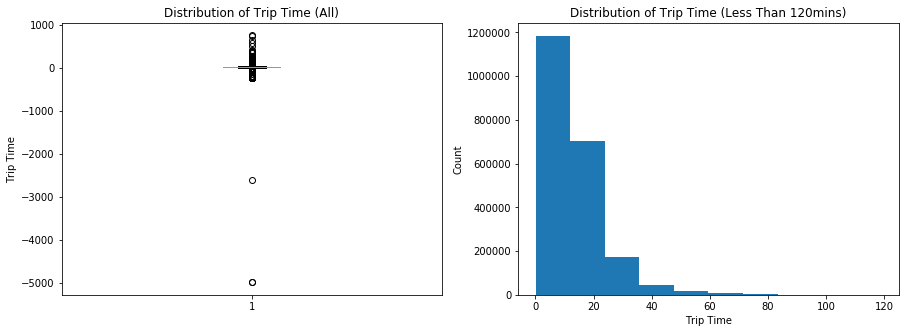

In [10]:
sampled_trip.loc[:,'trip_time'] = (sampled_trip['dropoff_datetime'] - 
                                   sampled_trip['pickup_datetime']) / pd.Timedelta(minutes=1)
fig,ax = plt.subplots(1,2,figsize = (15,5))
ax[0].boxplot(sampled_trip.loc[:,'trip_time']);
ax[1].hist(sampled_trip.loc[(sampled_trip['trip_time'] > 0) & 
                            (sampled_trip['trip_time'] < 120), 'trip_time']);
ax[0].set_ylabel('Trip Time');
ax[0].set_title('Distribution of Trip Time (All)');
ax[1].set_xlabel('Trip Time');
ax[1].set_ylabel('Count');
ax[1].set_title('Distribution of Trip Time (Less Than 120mins)');

In [11]:
# merge this into sql
sampled_trip = sampled_trip[sampled_trip['trip_time']>0].sort_values(['hack_license', 'pickup_datetime', 'dropoff_datetime'])
sampled_trip.loc[:, 'pickup_datetime_next'] = sampled_trip.groupby(['hack_license'])['pickup_datetime'].shift(-1)
sampled_trip.loc[:, 'dropoff_datetime_next'] = sampled_trip.groupby(['hack_license'])['dropoff_datetime'].shift(-1)
sampled_trip.loc[:, 'delta'] = (sampled_trip['pickup_datetime_next'] - sampled_trip['dropoff_datetime']) / pd.Timedelta(hours=1)
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,delta,trip_time
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,360,0.97,-73.992531,40.724052,-73.983841,40.731033,2013-06-24 19:12:00,2013-06-24 19:30:00,0.183333,6.0
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,1080,3.04,-73.982498,40.745617,-73.982628,40.777344,2013-06-24 19:45:00,2013-06-24 20:10:00,0.250000,18.0
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,1500,4.17,-73.981850,40.768753,-73.987068,40.726727,2013-06-24 20:17:00,2013-06-24 20:28:00,0.116667,25.0
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,660,2.35,-73.988129,40.738098,-73.965042,40.761581,2013-06-24 20:30:00,2013-06-24 20:35:00,0.033333,11.0
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,300,1.24,-73.961098,40.760826,-73.956833,40.774902,2013-06-24 20:37:00,2013-06-24 20:49:00,0.033333,5.0


# Trip distance

In [12]:
N = sampled_trip.shape[0]
n0 = len(sampled_trip.loc[(sampled_trip['trip_distance']<1), 'trip_distance'])
n1 = len(sampled_trip.loc[(sampled_trip['trip_distance']<20), 'trip_distance'])
print('{n0} ({n0_per:.2f}%) records: trip distance within 1 mile\n\
{n1} ({n1_per:.2f}%) records: trip distance within 20 mile'.format(n0 = n0, n0_per = n0/N*100,
                                                                   n1 = n1, n1_per = n1/N*100))

447701 (21.01%) records: trip distance within 1 mile
2121917 (99.59%) records: trip distance within 20 mile


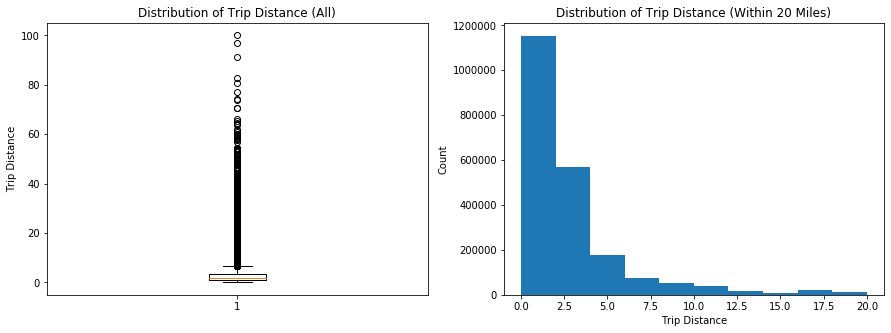

In [13]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
ax[0].boxplot(sampled_trip.loc[:, 'trip_distance']);
ax[1].hist(sampled_trip.loc[(sampled_trip['trip_distance']<20), 'trip_distance']);
ax[0].set_ylabel('Trip Distance');
ax[0].set_title('Distribution of Trip Distance (All)');

ax[1].set_xlabel('Trip Distance');
ax[1].set_ylabel('Count');
ax[1].set_title('Distribution of Trip Distance (Within 20 Miles)');

# Trip fare

In [14]:
trip_fare = pd.read_csv(path + 'FOIL2013/trip_fare_6.csv')
trip_fare.columns = trip_fare.columns.str.replace(' ','')
trip_fare.loc[:,'pickup_datetime'] = pd.to_datetime(trip_fare['pickup_datetime'])
trip_fare.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013009441,2013013593,VTS,2013-06-01,CSH,5.0,0.5,0.5,0.0,0.0,6.0
1,2013012081,2013019632,VTS,2013-06-01,CRD,14.5,0.5,0.5,1.5,0.0,17.0
2,2013006133,2013029678,VTS,2013-06-01,CSH,9.5,0.5,0.5,0.0,0.0,10.5
3,2013007864,2013007860,VTS,2013-06-01,CRD,8.0,0.5,0.5,1.7,0.0,10.7
4,2013010123,2013010123,VTS,2013-06-01,CSH,19.5,0.5,0.5,0.0,0.0,20.5


In [15]:
sampled_trip = sampled_trip.merge(trip_fare.drop(['vendor_id'], axis=1), on =['medallion','hack_license','pickup_datetime'])
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_datetime_next,delta,trip_time,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,360,0.97,-73.992531,...,2013-06-24 19:30:00,0.183333,6.0,CSH,6.0,1.0,0.5,0.0,0.0,7.5
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,1080,3.04,-73.982498,...,2013-06-24 20:10:00,0.250000,18.0,CRD,14.5,1.0,0.5,0.0,0.0,16.0
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,1500,4.17,-73.981850,...,2013-06-24 20:28:00,0.116667,25.0,CRD,17.5,1.0,0.5,3.7,0.0,22.7
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,660,2.35,-73.988129,...,2013-06-24 20:35:00,0.033333,11.0,CRD,10.5,0.5,0.5,2.2,0.0,13.7
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,300,1.24,-73.961098,...,2013-06-24 20:49:00,0.033333,5.0,CSH,6.0,0.5,0.5,0.0,0.0,7.0


In [16]:
N = sampled_trip.shape[0]
n0 = len(sampled_trip.loc[(sampled_trip['total_amount']==0), 'total_amount'])
n1 = len(sampled_trip.loc[(sampled_trip['total_amount']<100), 'total_amount'])
print('{n0} ({n0_per:.2f}%) records: trip fare = 0\n\
{n1} ({n1_per:.2f}%) records: trip fare < 100'.format(n0 = n0, n0_per = n0/N*100,
                                                     n1 = n1, n1_per = n1/N*100))

0 (0.00%) records: trip fare = 0
2128731 (99.91%) records: trip fare < 100


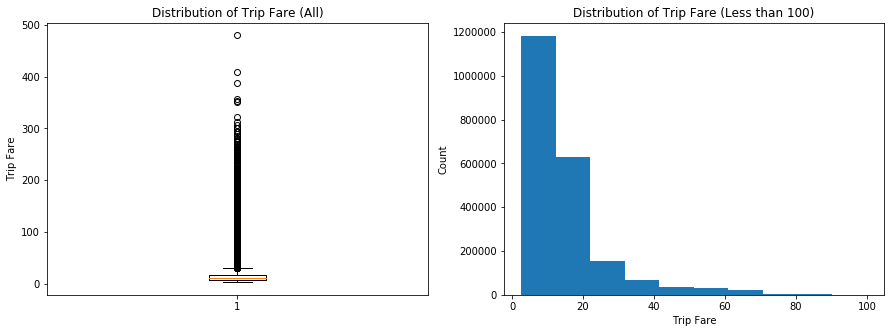

In [17]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
ax[0].boxplot(sampled_trip.loc[:, 'total_amount']);
ax[1].hist(sampled_trip.loc[(sampled_trip['total_amount']<100), 'total_amount']);
ax[0].set_ylabel('Trip Fare');
ax[0].set_title('Distribution of Trip Fare (All)');

ax[1].set_xlabel('Trip Fare');
ax[1].set_ylabel('Count');
ax[1].set_title('Distribution of Trip Fare (Less than 100)');

- k=3, 63 (0.003%) active time > 24h
- k=4, 116 (0.005%) active time > 24h
- k=5, 186 (0.009%) active time > 24h

In [14]:
k=4

## If delta > k, the trip is the last drop off of the shift
## And the next trip of the driver is the first pickup (shifted)
sampled_trip['last_dropoff'] = [1 if d > k else 0 for d in sampled_trip['delta']]
sampled_trip['first_pickup'] = sampled_trip.groupby('hack_license')['last_dropoff'].shift(1)
sampled_trip.dropna(subset=['pickup_datetime_next', 'dropoff_datetime_next'], inplace=True) 
sampled_trip['first_pickup'].fillna(0, inplace=True)

In [15]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,delta,last_dropoff,first_pickup
0,2013000005,2013000005,VTS,1,2013-06-01 15:05:00,2013-06-01 15:08:00,5,180,0.42,-73.976631,40.790504,-73.971565,40.787315,2013-06-01 15:12:00,2013-06-01 15:26:00,0.066667,0,0.0
1,2013000005,2013000005,VTS,1,2013-06-01 15:12:00,2013-06-01 15:26:00,3,840,2.80,-73.970322,40.784058,-73.990753,40.750889,2013-06-01 15:31:00,2013-06-01 15:46:00,0.083333,0,0.0
2,2013000005,2013000005,VTS,1,2013-06-01 15:31:00,2013-06-01 15:46:00,4,900,2.16,-73.995903,40.743778,-73.987251,40.722488,2013-06-01 15:49:00,2013-06-01 16:00:00,0.050000,0,0.0
3,2013000005,2013000005,VTS,1,2013-06-01 15:49:00,2013-06-01 16:00:00,3,660,2.63,-73.983421,40.721920,-74.002678,40.706558,2013-06-01 16:02:00,2013-06-01 16:14:00,0.033333,0,0.0
4,2013000005,2013000005,VTS,1,2013-06-01 16:02:00,2013-06-01 16:14:00,4,720,2.57,-74.002991,40.706398,-74.004395,40.728592,2013-06-01 16:18:00,2013-06-01 16:29:00,0.066667,0,0.0


In [16]:
## Extract hour and day
sampled_trip['dropoff_hour'] = sampled_trip.dropoff_datetime.dt.hour
sampled_trip['pickup_hour'] = sampled_trip.pickup_datetime.dt.hour
sampled_trip['dropoff_day'] = sampled_trip.dropoff_datetime.dt.date
sampled_trip['pickup_day'] = sampled_trip.pickup_datetime.dt.date
sampled_trip['pickup_weekday'] = (sampled_trip.loc[:,'pickup_datetime'].dt.dayofweek // 5 == 0).astype(int)
sampled_trip['dropoff_weekday'] = (sampled_trip.loc[:,'dropoff_datetime'].dt.dayofweek // 5 == 0).astype(int)


In [21]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,tolls_amount,total_amount,last_dropoff,first_pickup,dropoff_hour,pickup_hour,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,360,0.97,-73.992531,...,0.0,7.5,0,0.0,19,18,2013-06-24,2013-06-24,1,1
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,1080,3.04,-73.982498,...,0.0,16.0,0,0.0,19,19,2013-06-24,2013-06-24,1,1
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,1500,4.17,-73.981850,...,0.0,22.7,0,0.0,20,19,2013-06-24,2013-06-24,1,1
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,660,2.35,-73.988129,...,0.0,13.7,0,0.0,20,20,2013-06-24,2013-06-24,1,1
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,300,1.24,-73.961098,...,0.0,7.0,0,0.0,20,20,2013-06-24,2013-06-24,1,1


# First pick-up and last drop-off distribution
- Two peaks of pick-up time: 6:00 am, 5:00 pm
- Two peaks of drop-off time: 1:00 am, 4:00 pm
- The pick-up peak on weekend morning appears later: 7:00 am
- The drop-off peak on weekend midnight appears later: 4:00 am

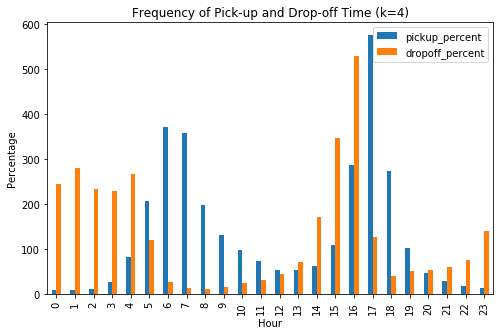

In [22]:
## Compute percentage

pickup_df = sampled_trip.loc[sampled_trip['first_pickup'] == 1]
pickup_per = pickup_df.groupby(['pickup_day', 'pickup_hour', 'pickup_weekday'])['pickup_hour'].count()
# pickup_per = pickup_per.groupby('pickup_day').apply(lambda x: x / x.sum() * 100)
pickup_per = pd.DataFrame(pickup_per).rename(columns={'pickup_hour':'pickup_percent'}).reset_index().\
                                        rename(columns={'pickup_day':'date',
                                                        'pickup_hour':'hour',
                                                           'pickup_weekday': 'weekday'})

dropoff_df = sampled_trip.loc[sampled_trip['last_dropoff'] == 1]
dropoff_per = dropoff_df.groupby(['dropoff_day', 'dropoff_hour', 'dropoff_weekday'])['dropoff_hour'].count()
# dropoff_per = dropoff_per.groupby('dropoff_day').apply(lambda x: x / x.sum() * 100)
dropoff_per = pd.DataFrame(dropoff_per).rename(columns={'dropoff_hour':'dropoff_percent'}).reset_index().\
                                        rename(columns={'dropoff_day':'date',
                                                        'dropoff_hour':'hour',
                                                           'dropoff_weekday': 'weekday'})

pick_drop_per = pickup_per.merge(dropoff_per)
pick_drop_per.head()


# % of Pick-up and Drop-off Time
pick_drop_per_all = pick_drop_per.groupby(['hour'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(figsize = (8,5))
pick_drop_per_all.plot(kind='bar',ax=ax);
ax.set_xlabel('Hour');
ax.set_ylabel('Percentage');
ax.set_title('Frequency of Pick-up and Drop-off Time (k={})'.format(k));
ax.legend();
fig.savefig(path + '../../img/pick_drop_time(k_{}).png'.format(k));

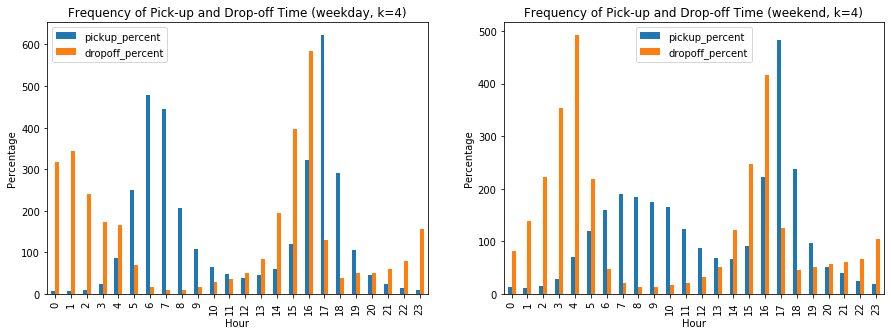

In [23]:
# Frequency of Pick-up and Drop-off Time (weekday and weekend)
pick_drop_per_wk = pick_drop_per.groupby(['hour','weekday'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(1,2,figsize = (15,5))
pick_drop_per_wk[pick_drop_per_wk.weekday == 1].drop('weekday',axis=1).plot(kind='bar',ax=ax[0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 0].drop('weekday',axis=1).plot(kind='bar',ax=ax[1]);
ax[0].set_xlabel('Hour');
ax[0].set_ylabel('Percentage');
ax[0].set_title('Frequency of Pick-up and Drop-off Time (weekday, k={})'.format(k));
ax[0].legend();

ax[1].set_xlabel('Hour');
ax[1].set_ylabel('Percentage');
ax[1].set_title('Frequency of Pick-up and Drop-off Time (weekend, k={})'.format(k));
ax[1].legend();
fig.savefig(path + '../../img/pick_drop_time_wk(k_{}).png'.format(k));

# Active time
- The active time of most drivers is 8 to 10 hours

In [24]:
# compute active time 
# Active time = end time of the shift - start time of the shift
active_time = sampled_trip.loc[sampled_trip['last_dropoff'] == 1,
                               ['hack_license', 'dropoff_datetime','pickup_datetime_next']].\
                        rename(columns={'pickup_datetime_next':'start_datetime'}).\
                        sort_values(['hack_license','start_datetime'])

active_time['end_datetime'] = active_time.groupby(['hack_license'])['dropoff_datetime'].shift(-1)
active_time['active_hour'] = (active_time['end_datetime'] - active_time['start_datetime']) / pd.Timedelta(hours=1)
active_time = active_time.drop(['dropoff_datetime'], axis=1).dropna()
active_time.head()

,hack_license,start_datetime,end_datetime,active_hour
7,2013000001,2013-06-26 17:24:00,2013-06-27 00:44:00,7.333333
26,2013000001,2013-06-27 17:20:00,2013-06-28 01:26:00,8.100000
56,2013000001,2013-06-28 18:08:00,2013-06-29 02:58:00,8.833333
85,2013000001,2013-06-29 18:07:00,2013-06-30 04:49:00,10.700000
127,2013000015,2013-06-01 17:59:00,2013-06-02 04:36:00,10.616667


In [25]:
# drop incorrect record 
N = sampled_trip.shape[0]
n0 = active_time[(active_time.active_hour<0)].shape[0]
n1 = active_time[(active_time.active_hour>=24)].shape[0]
print('{n0} ({n0_per:.3f}%) records: drop-off time before pick-up time\n\
{n1} ({n1_per:.3f}%) records: active time > 24'.format(n0 = n0, n0_per = n0/N*100,
                                                       n1 = n1, n1_per = n1/N*100))

0 (0.000%) records: drop-off time before pick-up time
123 (0.006%) records: active time > 24


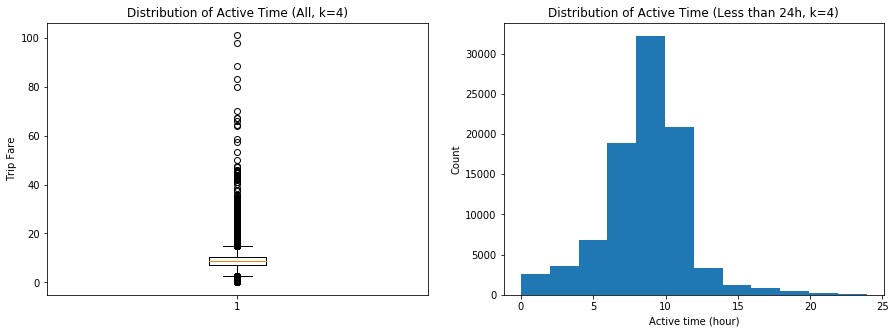

In [26]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
ax[0].boxplot(active_time.loc[:, 'active_hour']);
ax[1].hist(active_time.loc[(active_time['active_hour']<24), 'active_hour'], bins=12);
ax[0].set_ylabel('Trip Fare');
ax[0].set_title('Distribution of Active Time (All, k={})'.format(k));

ax[1].set_xlabel('Active time (hour)');
ax[1].set_ylabel('Count');
ax[1].set_title('Distribution of Active Time (Less than 24h, k={})'.format(k));
fig.savefig(path + '../../img/active_time(k_{}).png'.format(k));

# Pick-up and drop-off location

In [27]:
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon

In [28]:
# download map here: https://data.cityofnewyork.us/Health/Modified-Zip-Code-Tabulation-Areas-MODZCTA-Map/5fzm-kpwv
nyc_map = pd.read_csv(path + '../Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv')
nyc_map['geometry'] = nyc_map['the_geom'].apply(wkt.loads)
nyc_map = gpd.GeoDataFrame(nyc_map, crs='EPSG:4326').drop('the_geom', axis=1)

# download map here: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq
# nyc_map = gpd.read_file(path + '../Neighborhood Tabulation Areas (NTA).geojson')

# download map here: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u
# nyc_map = gpd.read_file(path + '../ZIP_CODE_040114/ZIP_CODE_040114.shp')

# download map here: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
# nyc_map = gpd.read_file(path +'../Borough_Boundaries/geo_export_573e53b9-f38f-46eb-be8d-0f07d0d0e9d1.shp')
nyc_map.head()

,MODZCTA,label,ZCTA,pop_est,geometry
0,10001,"10001, 10118","10001, 10119, 10199",23072,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 ..."
1,10002,10002,10002,74993,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ..."
2,10003,10003,10003,54682,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ..."
3,10004,10004,10004,3028,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ..."
4,10005,10005,"10005, 10271",8831,"MULTIPOLYGON (((-74.00783 40.70309, -74.00786 ..."


In [47]:
# drop gps records (roughly) outside of nyc 
nyc_loc = [-74.25,-73.75, 40.45, 40.95]
location_index = (sampled_trip['pickup_longitude'] > nyc_loc[0]) &   \
                    (sampled_trip['pickup_longitude'] < nyc_loc[1]) & \
                    (sampled_trip['pickup_latitude'] > nyc_loc[2]) & \
                    (sampled_trip['pickup_latitude'] < nyc_loc[3]) & \
                    (sampled_trip['dropoff_longitude'] > nyc_loc[0]) & \
                    (sampled_trip['dropoff_longitude'] < nyc_loc[1]) & \
                    (sampled_trip['dropoff_latitude'] > nyc_loc[2]) & \
                    (sampled_trip['dropoff_latitude'] < nyc_loc[3])
location_index = location_index[location_index==True].index.tolist()

N = sampled_trip.shape[0]
n0 = len(location_index)
print('{n0} ({n0_per:.2f}%) are roughly in NYC'.format(n0=n0, n0_per=n0/N*100))

2087155 (98.19%) are roughly in NYC


In [50]:
# location_index = sampled_trip.index.tolist()
features = ['hack_license','trip_distance',
            'dropoff_hour','pickup_hour',
            'pickup_longitude','pickup_latitude',
            'dropoff_longitude','dropoff_latitude']

sample_n = 5000
sample_index = sample(range(N), sample_n)

# convert the first pickup location to geometric form
pickup_location = sampled_trip.iloc[sample_index].loc[:, features]
pickup_location = gpd.GeoDataFrame(pickup_location, 
                                   geometry = gpd.points_from_xy(pickup_location['pickup_longitude'],
                                                                 pickup_location['pickup_latitude']))

# convert the last dropoff location to geometric form
dropoff_location = sampled_trip.iloc[sample_index].loc[:, features]
dropoff_location = gpd.GeoDataFrame(dropoff_location, 
                                    geometry = gpd.points_from_xy(dropoff_location['dropoff_longitude'],
                                                                  dropoff_location['dropoff_latitude']))

pickup_location.head()

,hack_license,trip_distance,dropoff_hour,pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,geometry
484263,2013007008,6.10,1,1,-73.973907,40.688091,-73.956482,40.745853,POINT (-73.97391 40.68809)
422265,2013006087,3.77,22,21,-73.988792,40.702621,-73.960144,40.674450,POINT (-73.98879 40.70262)
1002404,2013015456,0.59,8,8,-73.948723,40.782017,-73.954498,40.780182,POINT (-73.94872 40.78202)
825673,2013012656,2.10,14,14,-73.987236,40.733109,-73.968765,40.758179,POINT (-73.98724 40.73311)
761245,2013011616,3.40,8,8,-73.999954,40.727081,-73.989410,40.768154,POINT (-73.99995 40.72708)


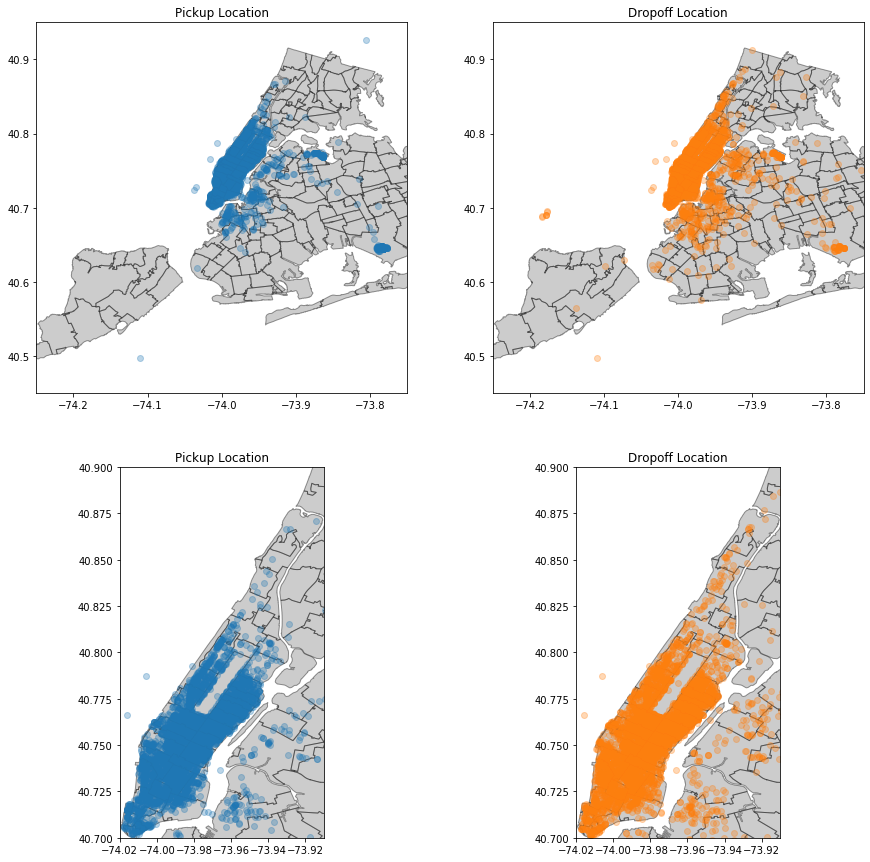

In [79]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
# add mapfile to axes
nyc_map.plot(ax=ax[0,0], alpha=0.4, edgecolor='k', color='grey');
pickup_location.plot(ax=ax[0,0], color='tab:blue', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[0,0].set_xlim(nyc_loc[0], nyc_loc[1]);
ax[0,0].set_ylim(nyc_loc[2], nyc_loc[3]);
ax[0,0].set_title('Pickup Location');

# add mapfile to axes
nyc_map.plot(ax=ax[0,1], alpha=0.4, edgecolor='k', color='grey');
dropoff_location.plot(ax=ax[0,1], color='tab:orange', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[0,1].set_xlim(nyc_loc[0], nyc_loc[1]);
ax[0,1].set_ylim(nyc_loc[2], nyc_loc[3]);
ax[0,1].set_title('Dropoff Location');

nyc_map.plot(ax=ax[1,0], alpha=0.4, edgecolor='k', color='grey');
pickup_location.plot(ax=ax[1,0], color='tab:blue', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[1,0].set_xlim(-74.02,-73.91);
ax[1,0].set_ylim( 40.7,40.9);
ax[1,0].set_title('Pickup Location');

# add mapfile to axes
nyc_map.plot(ax=ax[1,1], alpha=0.4, edgecolor='k', color='grey');
dropoff_location.plot(ax=ax[1,1], color='tab:orange', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[1,1].set_xlim(-74.02,-73.91);
ax[1,1].set_ylim( 40.7,40.9);
ax[1,1].set_title('Dropoff Location');

# Location of long-distance trip

In [66]:
threshold = 20
long_lon = pd.melt((sampled_trip.loc[sampled_trip['trip_distance'] > threshold,
                                     ['trip_distance','pickup_longitude','dropoff_longitude']]).
                   rename(columns={'pickup_longitude': 'pickup',
                                   'dropoff_longitude': 'dropoff'}),
                   id_vars = 'trip_distance').rename(columns={'value':'longitude'})
long_lat = pd.melt((sampled_trip.loc[sampled_trip['trip_distance'] > threshold,
                                     ['trip_distance','pickup_latitude','dropoff_latitude']]).
                   rename(columns={'pickup_latitude': 'pickup',
                                   'dropoff_latitude': 'dropoff'}),
                   id_vars = 'trip_distance').rename(columns={'value':'latitude'})

long_trip_location = long_lon
long_trip_location.loc[:,'latitude'] = long_lat['latitude']
long_trip_location = gpd.GeoDataFrame(long_trip_location, 
                                      geometry = gpd.points_from_xy(long_trip_location['longitude'],
                                                                    long_trip_location['latitude']))
# long_trip_location.loc[:, 'variable'] = [0 if v == 'pickup' else 1 for v in long_trip_location.variable]
long_trip_location.head()

,trip_distance,variable,longitude,latitude,geometry
0,29.45,pickup,-74.007927,40.740391,POINT (-74.00793 40.74039)
1,20.03,pickup,-73.969826,40.797493,POINT (-73.96983 40.79749)
2,20.51,pickup,-73.783775,40.648659,POINT (-73.78378 40.64866)
3,26.76,pickup,-73.781853,40.644840,POINT (-73.78185 40.64484)
4,21.12,pickup,-73.981857,40.774536,POINT (-73.98186 40.77454)


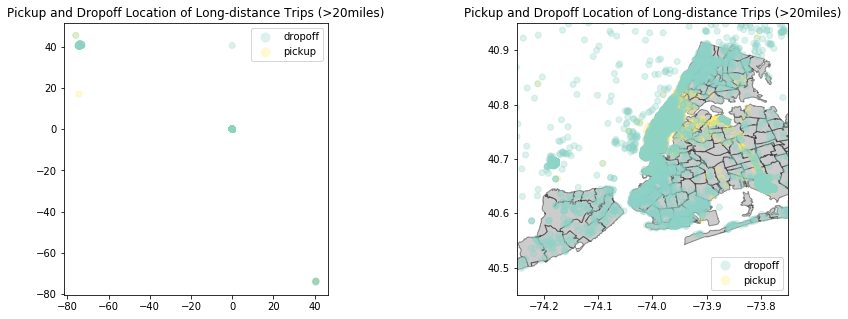

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# add mapfile to axes
nyc_map.plot(ax=ax[0], alpha=0.4, edgecolor='k', color='grey');
long_trip_location.plot(column='variable', ax=ax[0], legend=True, cmap='Set3', alpha=0.3);
ax[0].set_title('Pickup and Dropoff Location of Long-distance Trips (>20miles)');

nyc_map.plot(ax=ax[1], alpha=0.4, edgecolor='k', color='grey');
long_trip_location.plot(column='variable', ax=ax[1], legend=True, cmap='Set3', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[1].set_xlim(nyc_loc[0], nyc_loc[1]);
ax[1].set_ylim(nyc_loc[2], nyc_loc[3]);
ax[1].set_title('Pickup and Dropoff Location of Long-distance Trips (>20miles)');

# Active Time Estimation

* active time = last drop-off time - first pick-up time
* There are 2 shifts in a day. We define shift A and shift B. Early pickups are associated with later dropoffs and later pickups are associated with early dropoffs.

  ![Caption for the picture.](../fig/shift_range.png)
  
* The decision on the time ranges are based on the distributions presented above.
* There are about the same proportion of drivers in each shift.
* To simulate an active time of a driver, we
    1. randomly pick shift with 1/2 chance being in shift A (equally proportionated)
    2. randomly pick the first PU time from all PU times in the chosen shift
    3. randomly pick the last DO time from all DO times in the chosen shift (must be later than the chosen first PU time)

In [11]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,delta
0,2013000005,2013000005,VTS,1,2013-06-01 15:05:00,2013-06-01 15:08:00,5,180,0.42,-73.976631,40.790504,-73.971565,40.787315,2013-06-01 15:12:00,2013-06-01 15:26:00,0.066667
1,2013000005,2013000005,VTS,1,2013-06-01 15:12:00,2013-06-01 15:26:00,3,840,2.80,-73.970322,40.784058,-73.990753,40.750889,2013-06-01 15:31:00,2013-06-01 15:46:00,0.083333
2,2013000005,2013000005,VTS,1,2013-06-01 15:31:00,2013-06-01 15:46:00,4,900,2.16,-73.995903,40.743778,-73.987251,40.722488,2013-06-01 15:49:00,2013-06-01 16:00:00,0.050000
3,2013000005,2013000005,VTS,1,2013-06-01 15:49:00,2013-06-01 16:00:00,3,660,2.63,-73.983421,40.721920,-74.002678,40.706558,2013-06-01 16:02:00,2013-06-01 16:14:00,0.033333
4,2013000005,2013000005,VTS,1,2013-06-01 16:02:00,2013-06-01 16:14:00,4,720,2.57,-74.002991,40.706398,-74.004395,40.728592,2013-06-01 16:18:00,2013-06-01 16:29:00,0.066667


In [ ]:
There is a caveat in the current code. It is possible 

In [111]:
def get_shift(time, weekday=True, pickup=True):
    if weekday:
        if pickup:
            if (time > datetime.time(23, 30)) | (time <= datetime.time(11, 30)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(8, 30)) & (time <= datetime.time(20, 30)):
                return 'A'
            else:
                return 'B'            
    else: ## weekend
        if pickup:
            if (time > datetime.time(2, 0)) & (time <= datetime.time(14, 0)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(10, 0)) & (time <= datetime.time(22, 0)):
                return 'A'
            else:
                return 'B'        
        return None
    
def sample_start_end_time(first_last_trip_df, shift_prop, weekday_code):
    random_shift = np.random.choice(['A', 'B'], size=1, 
                                    p = shift_prop.loc[(shift_prop['pickup_weekday'] == weekday_code)][0].tolist())[0]
    # travel_time = datetime.timedelta(minutes=10)
#     print("random_shift: {}".format(random_shift))
    sampled_PU_time = first_last_trip_df.loc[(first_last_trip_df['_PU_shift'] == random_shift) &
                                            (first_last_trip_df['first_pickup'] == 1)]['PU_time'].sample().values[0]

    if random_shift == 'A':
        try:
            sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
#         print("-", sampled_DO_time)#
        except:
            print(random_shift)
            print(sampled_PU_time)
            print(first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)].shape)
            return None, None
    else: #shift B dropoff
        try:
            sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                ((first_last_trip_df['DO_time'] > sampled_PU_time) |
                                                 (first_last_trip_df['DO_time'] <= datetime.time(8,30)))  &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
        except:
            
            print(random_shift)
            print(sampled_PU_time)
            print(first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)].shape)
            return None, None
            #         print("-", sampled_DO_time) #.sample().values[0])
#     print("--Sampled PU time>> {}".format(sampled_PU_time))
#     print("--Sampled DO time>> {}".format(sampled_DO_time))
    
    return sampled_PU_time, sampled_DO_time



In [90]:
first_last_trip = sampled_trip.loc[(sampled_trip['first_pickup'] == 1) |
                                     (sampled_trip['last_dropoff'] == 1)]

first_last_trip.loc[:,'PU_time'] = first_last_trip['pickup_datetime'].apply(lambda x: x.time())
first_last_trip.loc[:,'DO_time'] = first_last_trip['dropoff_datetime'].apply(lambda x: x.time())


## determine shift for weekdays
first_last_trip.loc[(first_last_trip['pickup_weekday']==1) &
                      (first_last_trip['first_pickup']==1) , '_PU_shift'] = first_last_trip.PU_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=True))
first_last_trip.loc[(first_last_trip['dropoff_weekday']==1) &
                      (first_last_trip['last_dropoff']==1), '_DO_shift'] = first_last_trip.DO_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=False))

## determine shift for weekends
first_last_trip.loc[(first_last_trip['pickup_weekday']==0) &
                      (first_last_trip['first_pickup']==1) , '_PU_shift'] = first_last_trip.PU_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=True))
first_last_trip.loc[(first_last_trip['dropoff_weekday']==0) &
                      (first_last_trip['last_dropoff']==1), '_DO_shift'] = first_last_trip.DO_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=False))

In [84]:
proportion_table = first_last_trip.loc[first_last_trip['first_pickup'] == 1].groupby(['pickup_weekday', '_PU_shift']).size()\
                .groupby(['pickup_weekday']).apply(lambda x: x/x.sum()).reset_index()
proportion_table

,pickup_weekday,_PU_shift,0
0,0,A,0.510569
1,0,B,0.489431
2,1,A,0.493365
3,1,B,0.506635


## Simulate weekend active hours

In [51]:
def find_time_diff(original_do_time, original_pu_time):
    
    pu_time = datetime.datetime.combine(datetime.datetime(2020, 1,1), original_pu_time)
    if original_do_time < original_pu_time:
        do_time = datetime.datetime.combine(datetime.datetime(2020, 1,2), original_do_time)
    else:
        do_time = datetime.datetime.combine(datetime.datetime(2020, 1,1), original_do_time)
        
#     print(pu_time)
#     print(do_time)
    return (do_time - pu_time).total_seconds() / 3600
#     datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), d_list[0]) - datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), p_list[0])

In [110]:
first_last_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_hour,pickup_hour,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday,PU_time,DO_time,_PU_shift,_DO_shift
41,2013000005,2013000005,VTS,1,2013-06-02 03:31:00,2013-06-02 03:49:00,2,1080,6.07,-74.003357,...,3,3,2013-06-02,2013-06-02,0,0,03:31:00,03:49:00,NaN,B
42,2013000005,2013000005,VTS,1,2013-06-03 08:45:00,2013-06-03 09:07:00,3,1320,3.30,-73.941727,...,9,8,2013-06-03,2013-06-03,1,1,08:45:00,09:07:00,A,NaN
74,2013000005,2013000005,VTS,1,2013-06-03 21:55:00,2013-06-03 22:03:00,4,480,1.93,-73.955978,...,22,21,2013-06-03,2013-06-03,1,1,21:55:00,22:03:00,NaN,B
75,2013000005,2013000005,VTS,1,2013-06-04 08:47:00,2013-06-04 08:51:00,3,240,0.96,-73.960587,...,8,8,2013-06-04,2013-06-04,1,1,08:47:00,08:51:00,A,NaN
110,2013000005,2013000005,VTS,1,2013-06-04 21:20:00,2013-06-04 21:48:00,5,1680,15.33,-74.013466,...,21,21,2013-06-04,2013-06-04,1,1,21:20:00,21:48:00,NaN,B


In [113]:
p_list = []
d_list = []
active_time = {'weekday': [], 'weekend': []}
for t in range(100):
    pu,do = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 1],
                                 proportion_table, weekday_code=1)
#     p_list.append(pu)
#     d_list.append(do)
    try:
        active_time['weekday'].append(find_time_diff(do, pu))
    except:
        print('error in sampling (weekday)')
        
    pu,do = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 0],
                                 proportion_table, weekday_code=0)
    
    try:
        active_time['weekend'].append(find_time_diff(do, pu))
    except:
        print('error in sampling (weekend)')


Text(0.5, 0, 'Hour')

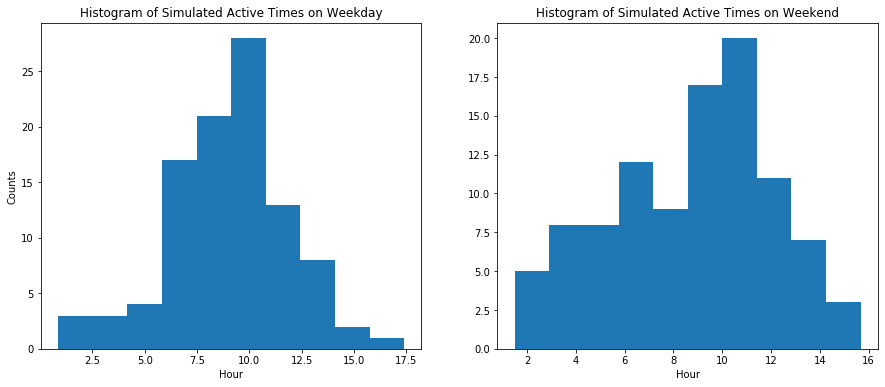

In [114]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].hist(active_time['weekday'])
ax[0].set_title('Histogram of Simulated Active Times on Weekday')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Counts')
ax[1].hist(active_time['weekend'])
ax[1].set_title('Histogram of Simulated Active Times on Weekend')
ax[1].set_xlabel('Hour')